In [1]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
import pinocchio as pin

from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.decomposition.asf import ASF

from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory, convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L, get_preset_by_index
from auto_robot_design.generator.topologies.bounds_preset import get_preset_by_index_with_bounds
from auto_robot_design.optimization.saver import ProblemSaver


In [2]:
import pinocchio as pin 


In [3]:
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G": body_density},
                              thickness={"default": thickness, "EE": 0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(
                                  MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
                              )

In [4]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_workspace_trajectory([-0.15, -0.35], 0.14, 0.3, 30, 60)))
# ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
#     starting_point=[-0.1, -0.31], step_height=0.05, step_width=0.2, n_points=50))

ground_symmetric_step1 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.14, -0.34], step_height=0.12, step_width=0.28, n_points=100)))

ground_symmetric_step2 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.14 + 0.015, -0.34], step_height=0.10, step_width=-2*(-0.14 + 0.015), n_points=100)))

ground_symmetric_step3 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.14 + 0.025 , -0.34], step_height=0.08, step_width=-2*(-0.14 + 0.025), n_points=100)))

central_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.34, 0.12, 0, 100)))

left_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.34, 0.12, -0.12, 100)))

right_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.34, 0.12, 0.12, 100)))
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(
    error_key='error', jacobian_key="Manip_Jacobian")
# soft_constrain = PositioningConstrain(
#     error_calculator=error_calculator, points=[workspace_trajectory])
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step1,
                                                                                   ground_symmetric_step2,
                                                                                   ground_symmetric_step3,
                                                                                   central_vertical,
                                                                                   left_vertical,
                                                                                   right_vertical])

# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step1, 0)
reward_manager.add_trajectory(ground_symmetric_step2, 1)
reward_manager.add_trajectory(ground_symmetric_step3, 2)

reward_manager.add_trajectory(central_vertical, 3)
reward_manager.add_trajectory(left_vertical, 4)
reward_manager.add_trajectory(right_vertical, 5)

reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(acceleration_capability, 1, 1)
reward_manager.add_reward(acceleration_capability, 2, 1)

reward_manager.add_reward(heavy_lifting, 3, 1)
reward_manager.add_reward(heavy_lifting, 4, 1)
reward_manager.add_reward(heavy_lifting, 5, 1)

reward_manager.add_trajectory_aggregator([0, 1, 2], 'mean')
reward_manager.add_trajectory_aggregator([3, 4, 5], 'mean')

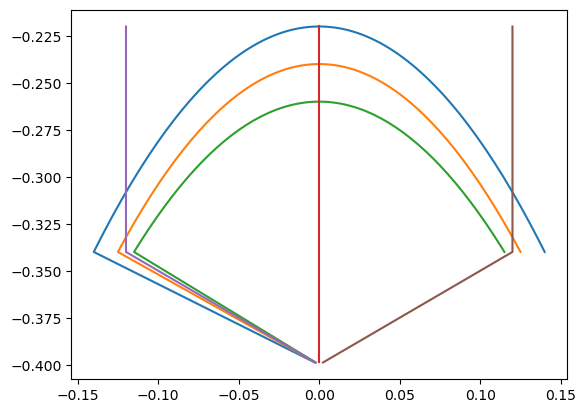

In [5]:
for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

plt.show()

In [6]:
pin.seed(1)
topology_index = 0
gm = get_preset_by_index_with_bounds(topology_index)
# activate multiprocessing
N_PROCESS = 16
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

population_size = 64
n_generations = 150

# create the problem for the current optimization
problem = MultiCriteriaProblem(gm, builder, reward_manager,
                               soft_constrain, elementwise_runner=runner, Actuator=actuator)

saver = ProblemSaver(problem, f"first_setup\\topology_{topology_index}", True)
saver.save_nonmutable()
algorithm = AGEMOEA2(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 2,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       64 |      3 |             - |             -
     2 |      128 |      5 |  0.0794287333 |             f
     3 |      192 |      8 |  0.1321691530 |         ideal
     4 |      256 |     11 |  0.2717414141 |         ideal
     5 |      320 |     17 |  0.1275997859 |         ideal
     6 |      384 |     22 |  0.1797490873 |         ideal
     7 |      448 |     25 |  0.0226151091 |             f
     8 |      512 |     33 |  0.1339945734 |         ideal
     9 |      576 |     37 |  0.0218553572 |         ideal
    10 |      640 |     47 |  0.0085299937 |         ideal
    11 |      704 |     60 |  0.0061509703 |         nadir
    12 |      768 |     62 |  0.0239938385 |         ideal
    13 |      832 |     64 |  0.0050361982 |             f
    14 |      896 |     64 |  0.0176909301 |         ideal
    15 |      960 |     64 |  0.0048258759 |             f
    16 |     1024 |     64 |  0.0042890235 |            

In [7]:
sf = problem.soft_constrain
# builder = problem.builder
# crag = problem.rewards_and_trajectories.crag


counter = 0
for i, x in enumerate(res.X):
    x= np.round(x, 5)
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    
    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter += 1
    else:
        __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
        print(res.F[i], vector_rewards)
counter

[-1.22209636 -4.48817525] [1.222073237101237, 4.488457063825466]
[-1.75334167 -2.20435783] [1.7532134056091309, 2.20543966104735]
[-1.13539267 -4.82788147] [1.1353636980056763, 4.827755448196874]
[-1.5147326  -3.38386447] [1.5148818890253704, 3.383107727548118]
[-1.1824009  -4.65200619] [1.182542363802592, 4.651547932543197]
[-1.65709559 -2.67271571] [1.657314618428548, 2.67125147376424]
[-1.62342385 -2.83013038] [1.623381495475769, 2.8306768585643804]
[-1.49751059 -3.45399103] [1.497835914293925, 3.452257373921363]
[-1.84077696 -1.55910496] [1.8407082557678223, 1.5589255815329113]
[-1.11719088 -4.88748963] [1.1174766222635906, 4.88612900384132]
[-1.17264855 -4.67290234] [1.1728705167770386, 4.672082502615928]
[-1.71736681 -2.35459676] [1.7172110080718994, 2.355198138568742]
[-1.2525684  -4.36445047] [1.252501090367635, 4.364930040823061]
[-1.12975025 -4.85468569] [1.129807670911153, 4.854237145319059]
[-1.30773381 -4.15237328] [1.3078723351160686, 4.151937454890685]
[-1.78459287 -2.02

0